In [1]:
import numpy as np
from rotation3sphere import align_to_north_pole
import matplotlib.pyplot as plt
import itertools as it

Here, the method of building the distance matrix via the family of geodesics connecting the antipodal points $(1,0)$ and $(-1, 0)$ is demonstrated.

The approach is based on the following steps:
1. Select a number of geodesics from the family by selecting appropriate pairs of parameters
2. Sample within these geodesics using Fibonacci grid sampling
3. Calculate pairwise Carnot-Carathéodory distances by rotating one point back into $(1,0)$ and applying the formula for the distance for a point $(z_1, z_2)$ from $(1,0)$.

The formula for the distance from $(1,0)$ is: $$d_{c-c} = | \arccos z_1 |$$
Here, $(z_1, z_2) \in \mathbb{S}^3 \subset \mathbb{C}^2$.

In [2]:
def get_z1(rho, u):
    return lambda s: np.exp(-1j*u*rho*s)*(np.cos(rho*s)+1j*u*np.sin(rho*s))

def get_z2(rho, u, alpha=0):
    r = 1 - u**2
    return lambda s: r*np.exp(-1j*(u*rho*s+alpha))*np.sin(rho*s)

def geodesic(m, p, number):
    """Sample geodesic between antipodal points (1,0), (-1,0)."""
    if not ( m == round(m) and m > 0 ):
        raise ValueError(f"m={m} is an invalid value. Should be a nonzero natural number.")
    rho = np.pi*m
    if m % 2:
        # m odd
        if not ( -(m-1)/2 <= p and p <= (m-1)/2 ):
            raise ValueError(f"p={p} is out of bounds for odd m={m}: {-(m-1)/2} <= p <= {(m-1)/2}")
        u = 2*p/m
    else:
        # m even
        if not ( -m/2 <= p and p <= m/2-1 ):
            raise ValueError(f"p={p} is out of bound for even m={m}: {-(m-1)/2} <= p <= {(m-1)/2}")
        u = (2*p+1)/m
    z1, z2 = get_z1(rho, u), get_z2(rho, u)
    return [ np.array([z1(s).real, z1(s).imag, z2(s).real, z2(s).imag]) for s in np.linspace(0, 1, number) ]

def geodesic_get_allowed_p(m):
    """Return a list of all allowed values of p for a given m."""
    if not ( m == round(m) and m > 0 ):
        raise ValueError(f"m={m} is an invalid value. Should be a nonzero natural number.")
    if m % 2:
        # m odd
        return list(range(-int((m-1)/2), int((m+1)/2)))
    else:
        # m even
        return list(range(-int(m/2), int(m/2)))

The function `distance(p, q)` uses the above formula for the Carnot-Carathéodory distance from $(1,0)$ to calculate the distance after rotating `p` to $(1,0)$.

In [3]:
def distance(p, q):
    p, q = align_to_north_pole(p, q)
    return np.abs(np.arccos(q[0]+1j*q[1]))

In [4]:
def build_squared_distance_matrix(points):
    """Build the matrix of squared distances from the arrray of points."""
    mat = np.zeros((len(points),)*2)
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            mat[i,j] = distance(points[i], points[j])
    return (mat + mat.T)**2

In [5]:
def geodesic_sample_points(m, n):
    """Sample points for multiple geodesics in family specified by m

    Samples n points from each geodesic parameterised by m, with all p allowed for a given m.

    Parameters:
    m   Parameter m for geodesics
    n   Number of points to sample for each geodesic

    Returns:
    List of (idx, point) tuples. idx is the index of the geodesic point was sampled from.
    """
    return list(it.chain(*[zip(it.repeat(idx), geodesic(m, p, n)) for idx, p in enumerate(geodesic_get_allowed_p(m))]))

In [6]:
points_geodesic_idxs, points_coords = zip(*geodesic_sample_points(5, 500))

In [7]:
def b_matrix(A):
    n_points = A.shape[0]
    H = np.identity(n_points) - np.ones((n_points, n_points)) / n_points
    return H@A@H

In [8]:
distances_squared = build_squared_distance_matrix(points_coords)
A = -0.5*distances_squared
B = b_matrix(A)

In [9]:
#linalg.eig already outputs normalized eigenvectors (wrt euclidean L2 norm)
eigvals, eigvecs = np.linalg.eig(B)

In [10]:
dimensions_target = 2
new_coords = eigvecs @ np.diag( np.max(np.vstack((eigvals, [0]*eigvals.size)), axis=0) ) @ eigvecs.T

/home/storkti/Downloads/test/jupyter/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/storkti/Downloads/test/jupyter/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


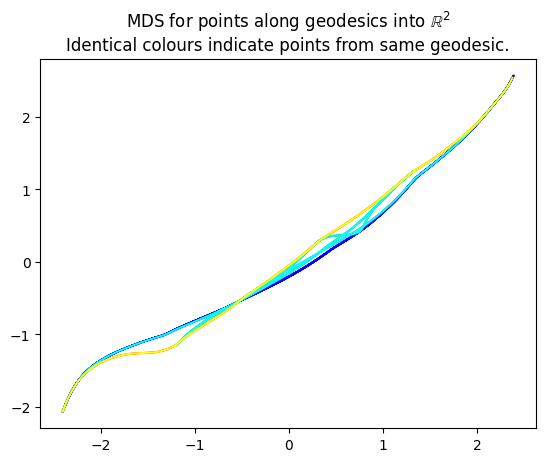

In [11]:
colours = ["red", "green", "blue", "cyan", "yellow", "magenta", "teal"]

for geodesic_idx, points in it.groupby(zip(new_coords[:dimensions_target,:].T, points_geodesic_idxs), key=lambda x: x[1]):
    points = list(map(lambda x: x[0], points))
    x, y = map(np.array, zip(*points))
    # totally arbitrary cutoff, used to discard a bunch of points
    # all projected to the same coordinates
    # probably related to the very small eigenvalues reported below
    selection = (x < 2.7)
    x = x[selection]
    y = y[selection]
    plt.plot(x,y, c=colours[geodesic_idx])
#plt.scatter(x, y, c=points_geodesic_idxs, cmap='Spectral')
plt.title("MDS for points along geodesics into $\\mathbb{R}^2$\nIdentical colours indicate points from same geodesic.")
plt.show()

In [12]:
small_thresh = 1e-8
print(f"There are {eigvals.size} eigenvalues.")
eigvals_semipos = np.max(np.vstack((eigvals, [0]*eigvals.size)).real, axis=0)
n_eigvals_semipos = sum(eigvals_semipos.flatten() > small_thresh)
print(f"Number of large, non-zero eigenvalues for approximate embedding: {n_eigvals_semipos} ({n_eigvals_semipos/eigvals.size*100:.2f}%)")

There are 2500 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 2432 (97.28%)


In [13]:
def plot_scatter_with_interpolation(x, y, point_idxs, cmap='viridis'):
    """
    Plots a scatter plot with points color-coded by geodesic they belong to and 
    adds interpolating lines for points within the same geodesic.

    Parameters:
    - x (array-like): x-coordinates of points.
    - y (array-like): y-coordinates of points.
    - point_idxs (array-like): Group index for each point (used for color coding).
    - cmap (str): Colormap to use for the groups (default: 'Spectral').
    """
    colormap = plt.get_cmap(cmap)
    
    unique_idxs = np.unique(point_idxs)
    norm = plt.Normalize(vmin=min(unique_idxs), vmax=max(unique_idxs))
    
    #plt.scatter(x, y, c=point_idxs, cmap=cmap, label="Scatter Points")
    
    # Interpolate points and plot lines for each group
    for group in unique_idxs:
        mask = point_idxs == group
        x_group = np.array(x)[mask]
        y_group = np.array(y)[mask]
        
        sorted_indices = np.argsort(x_group)
        x_group = x_group[sorted_indices]
        y_group = y_group[sorted_indices]
        
        if len(x_group) > 1: 
            x_interp = np.linspace(x_group[0], x_group[-1], 200)
            y_interp = np.interp(x_interp.real, x_group.real, y_group.real)
            
            # Plot the interpolated line with the same color as the group
            plt.plot(x_interp, y_interp, color=colormap(norm(group)), label=f"Geodesic {group}", linewidth=7-group)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Geodesics via MDS and grouped interpolations")
    plt.legend()
    plt.savefig("geodesics7.png")
    plt.show()

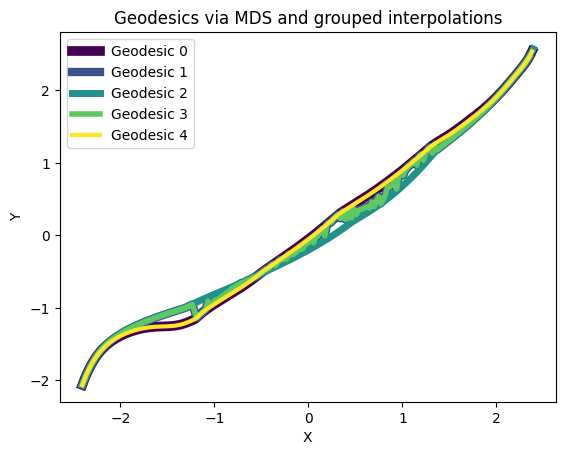

In [14]:
x, y = new_coords[:dimensions_target,:]
selection = (x < 2.7)
plot_scatter_with_interpolation(x[selection], y[selection], np.array(points_geodesic_idxs)[selection])

In [15]:
def fibonaccigrid_sampling(n):
    phi = (1 + np.sqrt(5)) / 2  
    
    # Initialize arrays for Cartesian coordinates
    points = np.zeros((n, 4))
    
    for k in range(n):
        #Compute angles using the index k and n points
        theta = np.arccos(1 - 2 * (k + 0.5) / n)  # Range [0, π]
        phi_k = 2 * np.pi * (k / phi**2)          # Range [0, 2π], scaled by golden ratio squared
        psi_k = 2 * np.pi * (k / phi**3)          # Additional rotation for 3rd angle, golden ratio cubed
        
        #Convert spherical coordinates to Cartesian coordinates in 4D
        points[k, 0] = np.cos(theta)
        points[k, 1] = np.sin(theta) * np.cos(phi_k)
        points[k, 2] = np.sin(theta) * np.sin(phi_k) * np.cos(psi_k)
        points[k, 3] = np.sin(theta) * np.sin(phi_k) * np.sin(psi_k)
    
    return points

In [65]:
def mds(points, dimensions_target=2):
    """Calculate distances and run MDS scheme on points.

    dimensions_target is the target dimensionality.
    New coordinates are returned such that unpacking into separate coordinates is possible, i.e.
      x, y, … = mds(…)
    """
    distances = build_squared_distance_matrix(points)
    A = -0.5*distances
    B = b_matrix(A)
    eigvals, eigvecs = np.linalg.eig(B)
    new_coords = eigvecs @ np.diag( np.max(np.vstack((eigvals, [0]*eigvals.size)), axis=0) ) @ eigvecs.T
    return new_coords[:dimensions_target,:]

In [66]:
points_fibonacci = fibonaccigrid_sampling(500)
points_geodesic_idxs, points_coords = zip(*geodesic_sample_points(5, 400))
points_geodesics = np.array(points_coords)

points = np.vstack((points_geodesics, points_fibonacci))
x, y = mds(points)

In [67]:
def compress(arr, low, high):
    return (((arr - arr.min()) * (high - low)) / (arr.max() - arr.min())) + low

/home/storkti/Downloads/test/jupyter/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


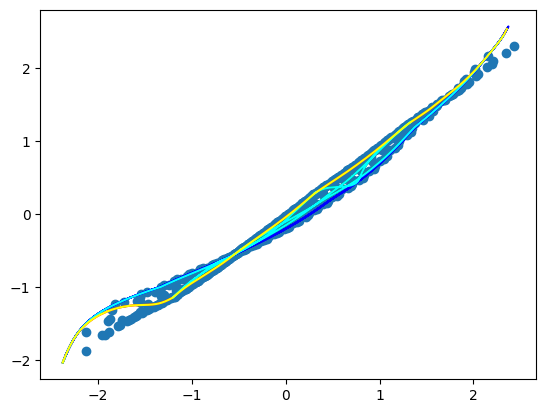

In [68]:
colours = ["red", "green", "blue", "cyan", "yellow", "magenta", "teal"]

for geodesic_idx, points in it.groupby(zip(zip(x[:len(points_geodesics)], y[:len(points_geodesics)]), points_geodesic_idxs), key=lambda x: x[1]):
    points = list(map(lambda x: x[0], points))
    xp, yp = map(np.array, zip(*points))
    # totally arbitrary cutoff, used to discard a bunch of points
    # all projected to the same coordinates
    # probably related to the very small eigenvalues reported below
    selection = (xp < 2.7)
    xp = xp[selection]
    yp = yp[selection]
    plt.plot(xp, yp, c=colours[geodesic_idx])

plt.scatter(x[len(points_geodesics):], y[len(points_geodesics):])
plt.savefig("envelope.png", bbox_inches='tight')
plt.show()